# Mock Approval dataset by CTAB-GAN
### ***Introduction***
CTAB-GAN is a conditional GAN based tabular data generator. CTAB-GAN advances beyond the prior state-of-the-art methods by modeling mixed variables and provides strong generation capability for imbalanced categorical variables, and continuous variables with complex distributions. To such ends, the core features of CTAB-GAN include as follows:
- (i)introduction of the classifier into conditional GAN;    
- (ii) effective data encoding for mixed variable;    
- (iii) a novel construction of conditional vectors.            

This dataset originates from Quinlan (see below).   
- (1) Title: Australian Credit Approval  
- (2) Sources: (confidential) Submitted by quinlan@cs.su.oz.au     
- (3) Relevant Information: This file concerns credit card applications. All attribute names and values have been changed to meaningless symbols to protect confidentiality of the data. This dataset is interesting because there is a good mix of attributes -- continuous, nominal with small numbers of values, and nominal with larger numbers of values. There are also a few missing values.     
- (4)  Number of Instances: 690    
- (5)  Number of Attributes: 14 + class attribute     
- (6)  Attribute Information:    
THERE ARE 6 NUMERICAL AND 8 CATEGORICAL ATTRIBUTES.       
THE LABELS HAVE BEEN CHANGED FOR THE CONVENIENCE OF THE STATISTICAL ALGORITHMS.     
FOR EXAMPLE, ATTRIBUTE 4 ORIGINALLY HAD 3 LABELS p,g,gg AND THESE HAVE BEEN CHANGED TO LABELS 1,2,3.                   
### ***Our work***   
We use CTAB-GAN to simulate Appraval data and visualize real and fake data. See code, comments, and diagrams for details.             
### ***Reference:***
[1] R. Quinlan (1987). Statlog (Australian Credit Approval) [Dataset]. UCI Machine Learning Repository. Available: http://archive.ics.uci.edu/dataset/143/statlog+australian+credit+approval           
[2] Z. Zhao, A. Kunar, R. Birke, and L. Y. Chen, “CTAB-GAN: Effective Table Data Synthesizing,” in Asian Conference on Machine Learning. PMLR, 2021, pp. 97–112.   

***Time ： 2024/11/26 23:14***  
***Author ： Chuang Liu***  
***Email ：LIUC0316@126.COM***  
***File ：Approval_Mocking.ipynb***  
***Notebook ：Jupyter***   

In [1]:
# Importing the model
from model.ctabgan import CTABGAN
# Importing the evaluation metrics 
from model.eval.evaluation import get_utility_metrics,stat_sim,privacy_metrics
# Importing standard libraries
import numpy as np
import pandas as pd
import glob

In [2]:
# Specifying the replication number 
num_exp = 1 
# Specifying the name of the dataset used 
dataset = "Approval" 
# Specifying the patah of the dataset used 
real_path = "Real_Datasets/Approval/Approval.csv" 
# Specifying the root directory for storing generated data
fake_file_root = "Fake_Datasets" 

In [5]:
# Initializing the synthesizer object and specifying input parameters
# Notice: If you have continuous variable, you do not need to explicitly assign it. It will be treated like 
# that by default
synthesizer =  CTABGAN(raw_csv_path = real_path,
                 test_ratio = 0.20,  
                 categorical_columns = ['F1', 'F4', 'F5', 'F6', 'F8', 'F9', 'F11', 'F12', 'T1'], 
                 log_columns = [],
                 mixed_columns= {'F3':[0.0],'F7':[0.0], 'F10':[0.0], 'F13':[0.0], 'F14':[0.0]}, 
                 integer_columns = ['F10', 'F13','F14'],
                 problem_type= {"Classification": 'T1'},
                 epochs = 1000) 

# Fitting the synthesizer to the training dataset and generating synthetic data
for i in range(num_exp):
    synthesizer.fit()
    syn = synthesizer.generate_samples()
    syn.to_csv(fake_file_root+"/"+dataset+"/"+ dataset+"_fake_{exp}.csv".format(exp=i), index= False)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:59<00:00,  1.28it/s]

Finished training in 780.1293773651123  seconds.


In [6]:
# Collecting the paths to all corresponding generated datasets for evaluation 
fake_paths = glob.glob(fake_file_root+"/"+dataset+"/"+"*")

In [7]:
# Specifying the list of classifiers to conduct ML utility evaluation
classifiers_list = ["lr","dt","rf","mlp","svm"]

# Storing and presenting the results as a dataframe
result_mat = get_utility_metrics(real_path,fake_paths,"MinMax",classifiers_list, test_ratio = 0.20)
result_df  = pd.DataFrame(result_mat,columns=["Acc","AUC","F1_Score"])
result_df.index = classifiers_list
result_df

,Acc,AUC,F1_Score
lr,2.173913,0.008090,0.021730
dt,34.782609,0.320204,0.371492
rf,0.000000,0.031722,0.000165
mlp,2.898551,0.044496,0.028992
svm,0.724638,0.031935,0.010222


In [8]:
# Specifying the categorical columns of the dataset used
adult_categorical = ['F1', 'F4', 'F5', 'F6', 'F8', 'F9', 'F11', 'F12', 'T1']

# Storing and presenting the results as a dataframe
stat_res_avg = []
for fake_path in fake_paths:
    stat_res = stat_sim(real_path,fake_path,adult_categorical)
    stat_res_avg.append(stat_res)

stat_columns = ["Average WD (Continuous Columns","Average JSD (Categorical Columns)","Correlation Distance"]
stat_results = pd.DataFrame(np.array(stat_res_avg).mean(axis=0).reshape(1,3),columns=stat_columns)
stat_results

,Average WD (Continuous Columns,Average JSD (Categorical Columns),Correlation Distance
0,0.012595,0.071076,0.0


In [9]:
# Storing and presenting the results as a dataframe
priv_res_avg = []
for fake_path in fake_paths:
    priv_res = privacy_metrics(real_path,fake_path)
    priv_res_avg.append(priv_res)
    
privacy_columns = ["DCR between Real and Fake (5th perc)","DCR within Real(5th perc)","DCR within Fake (5th perc)","NNDR between Real and Fake (5th perc)","NNDR within Real (5th perc)","NNDR within Fake (5th perc)"]
privacy_results = pd.DataFrame(np.array(priv_res_avg).mean(axis=0).reshape(1,6),columns=privacy_columns)
privacy_results

,DCR between Real and Fake (5th perc),DCR within Real(5th perc),DCR within Fake (5th perc),NNDR between Real and Fake (5th perc),NNDR within Real (5th perc),NNDR within Fake (5th perc)
0,1.02019,0.84307,0.913817,0.53251,0.414569,0.566872


In [10]:
from table_evaluator import TableEvaluator

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   F1      690 non-null    int64  
 1   F2      690 non-null    float64
 2   F3      690 non-null    float64
 3   F4      690 non-null    int64  
 4   F5      690 non-null    int64  
 5   F6      690 non-null    int64  
 6   F7      690 non-null    float64
 7   F8      690 non-null    int64  
 8   F9      690 non-null    int64  
 9   F10     690 non-null    int64  
 10  F11     690 non-null    int64  
 11  F12     690 non-null    int64  
 12  F13     690 non-null    int64  
 13  F14     690 non-null    int64  
 14  T1      690 non-null    int64  
dtypes: float64(3), int64(12)
memory usage: 81.0 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   F1      690 non-null    int64 

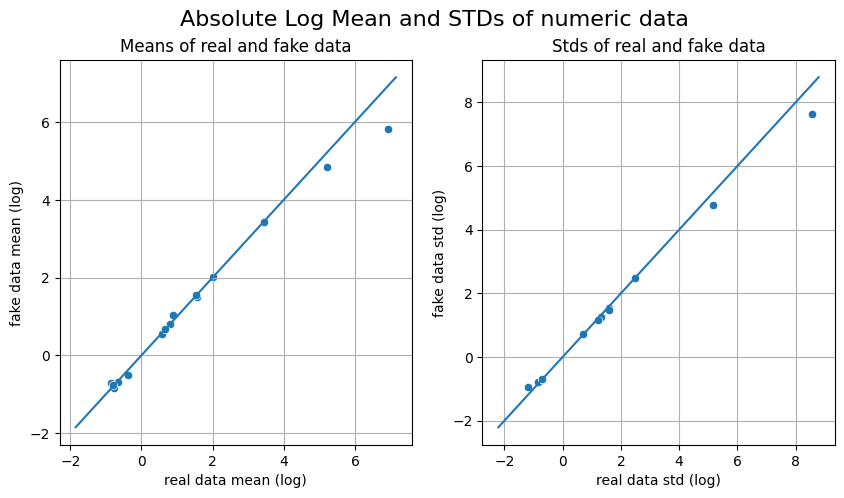

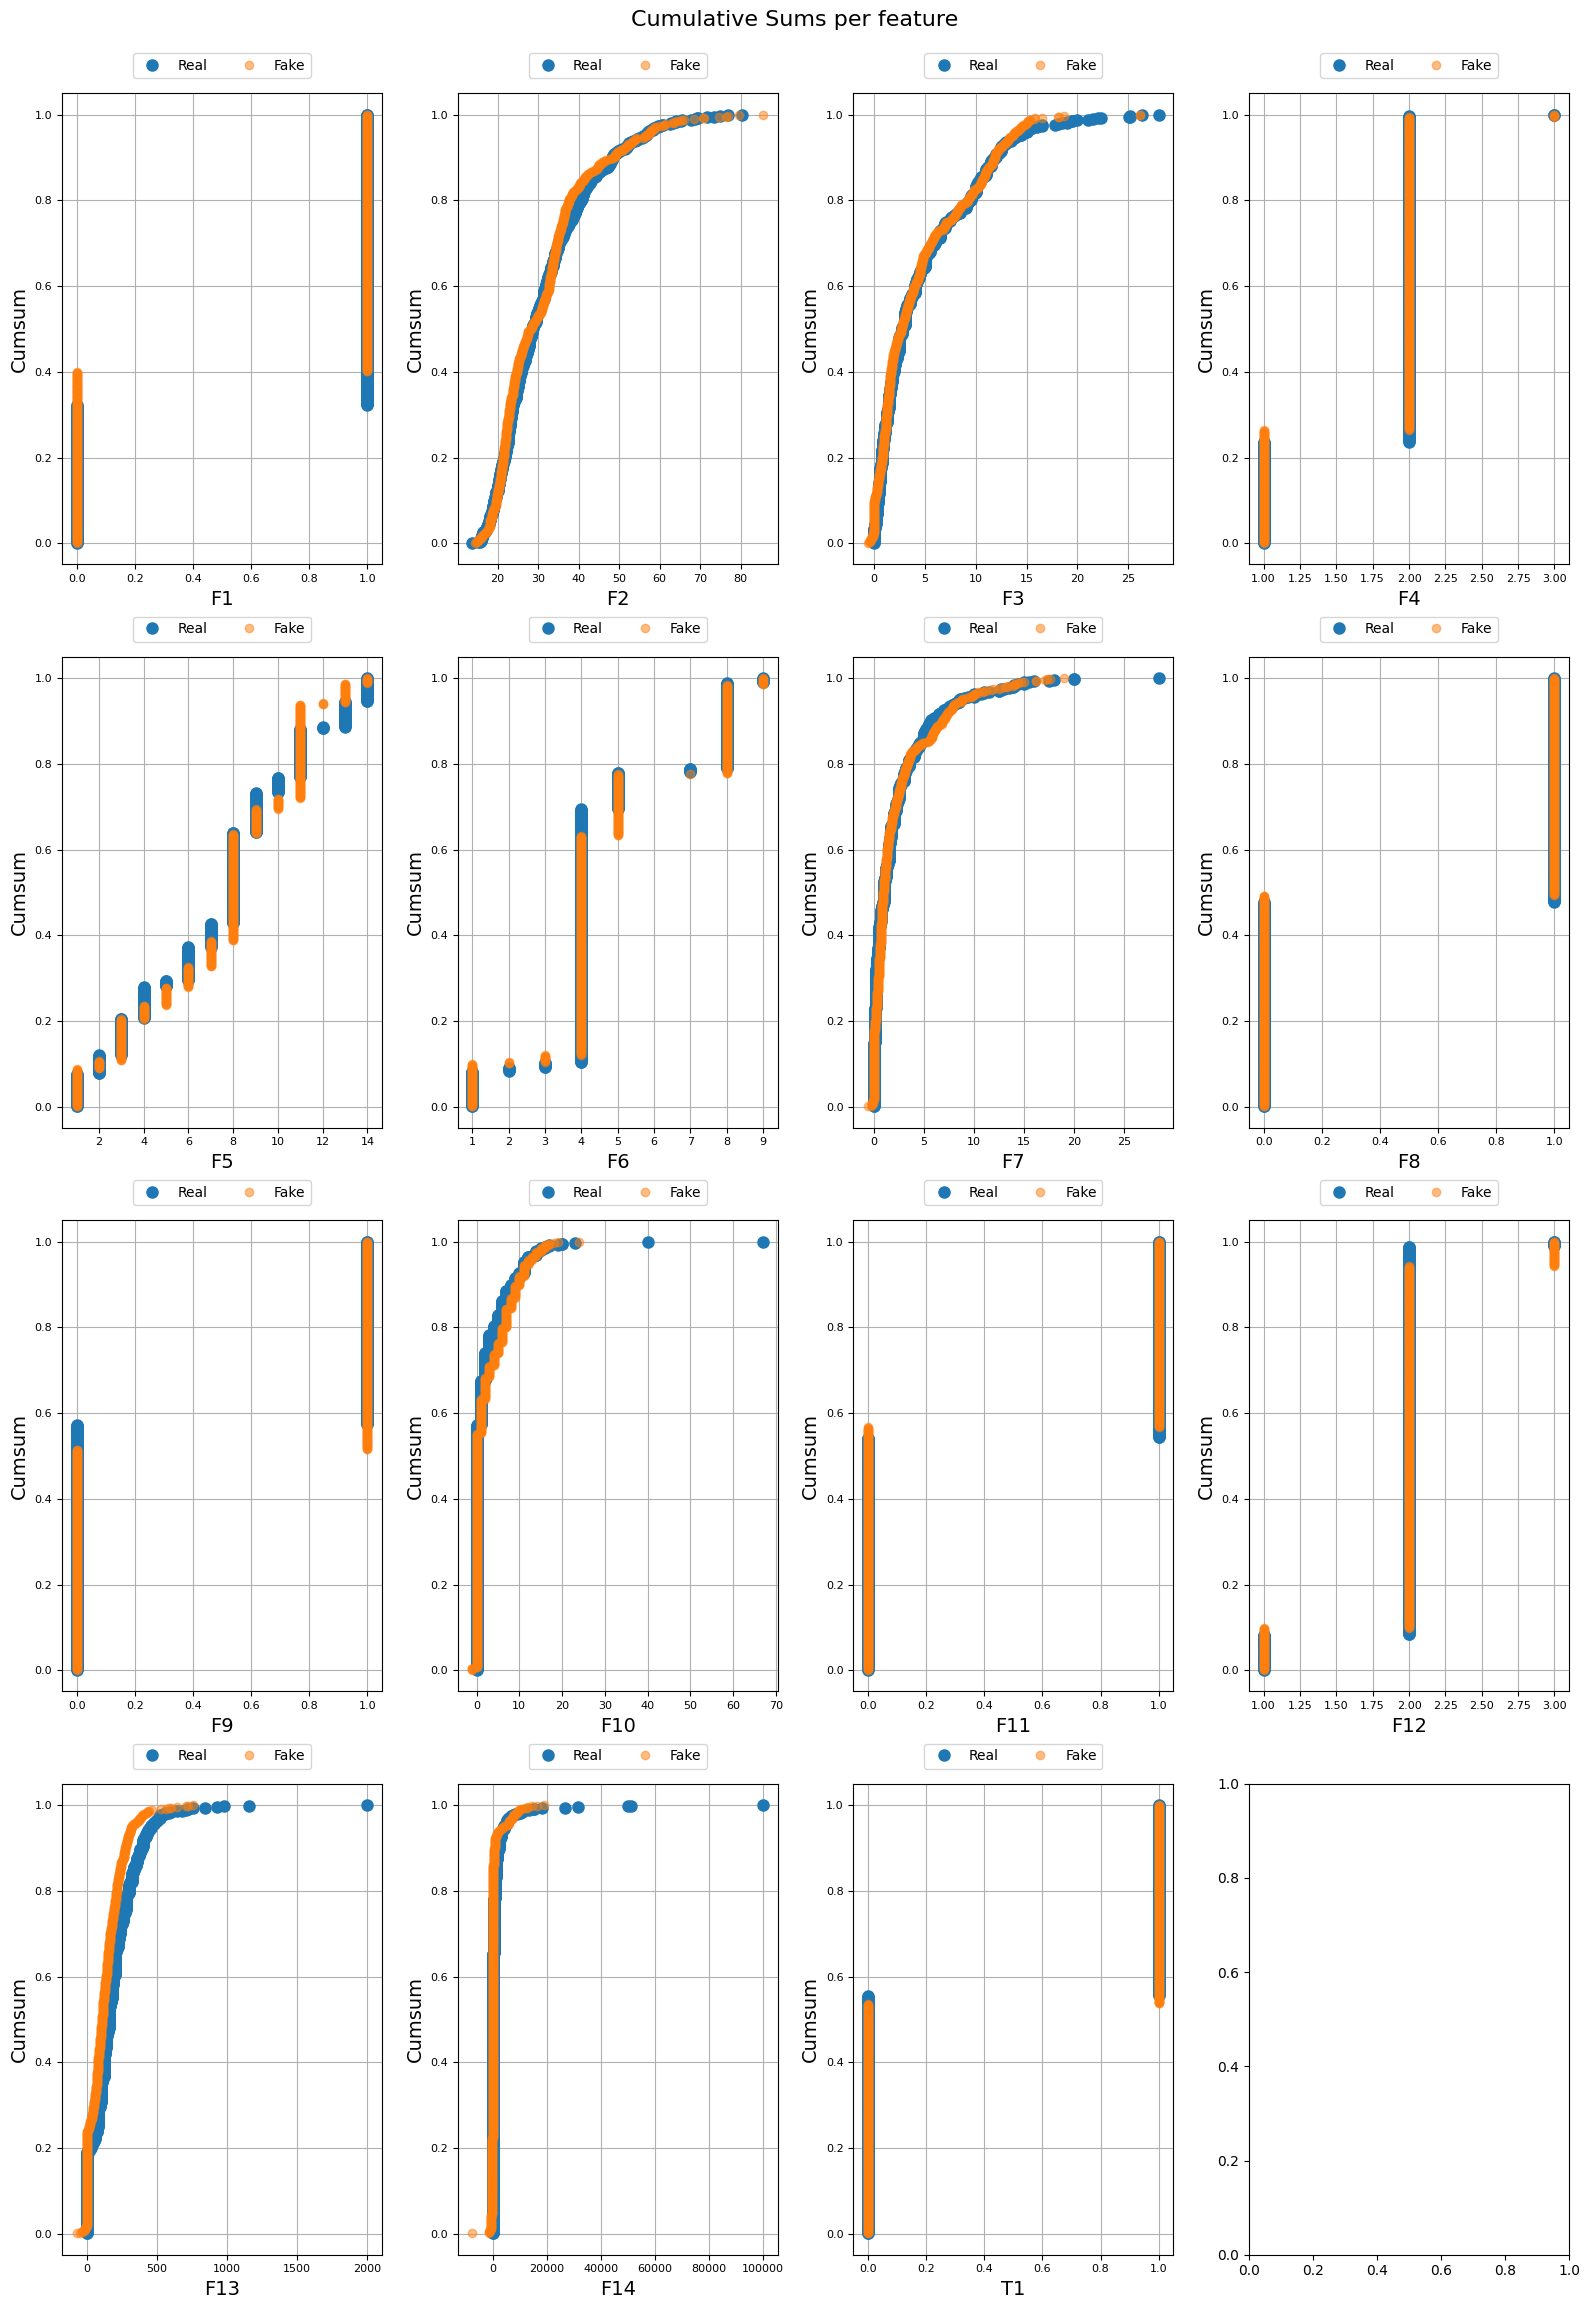

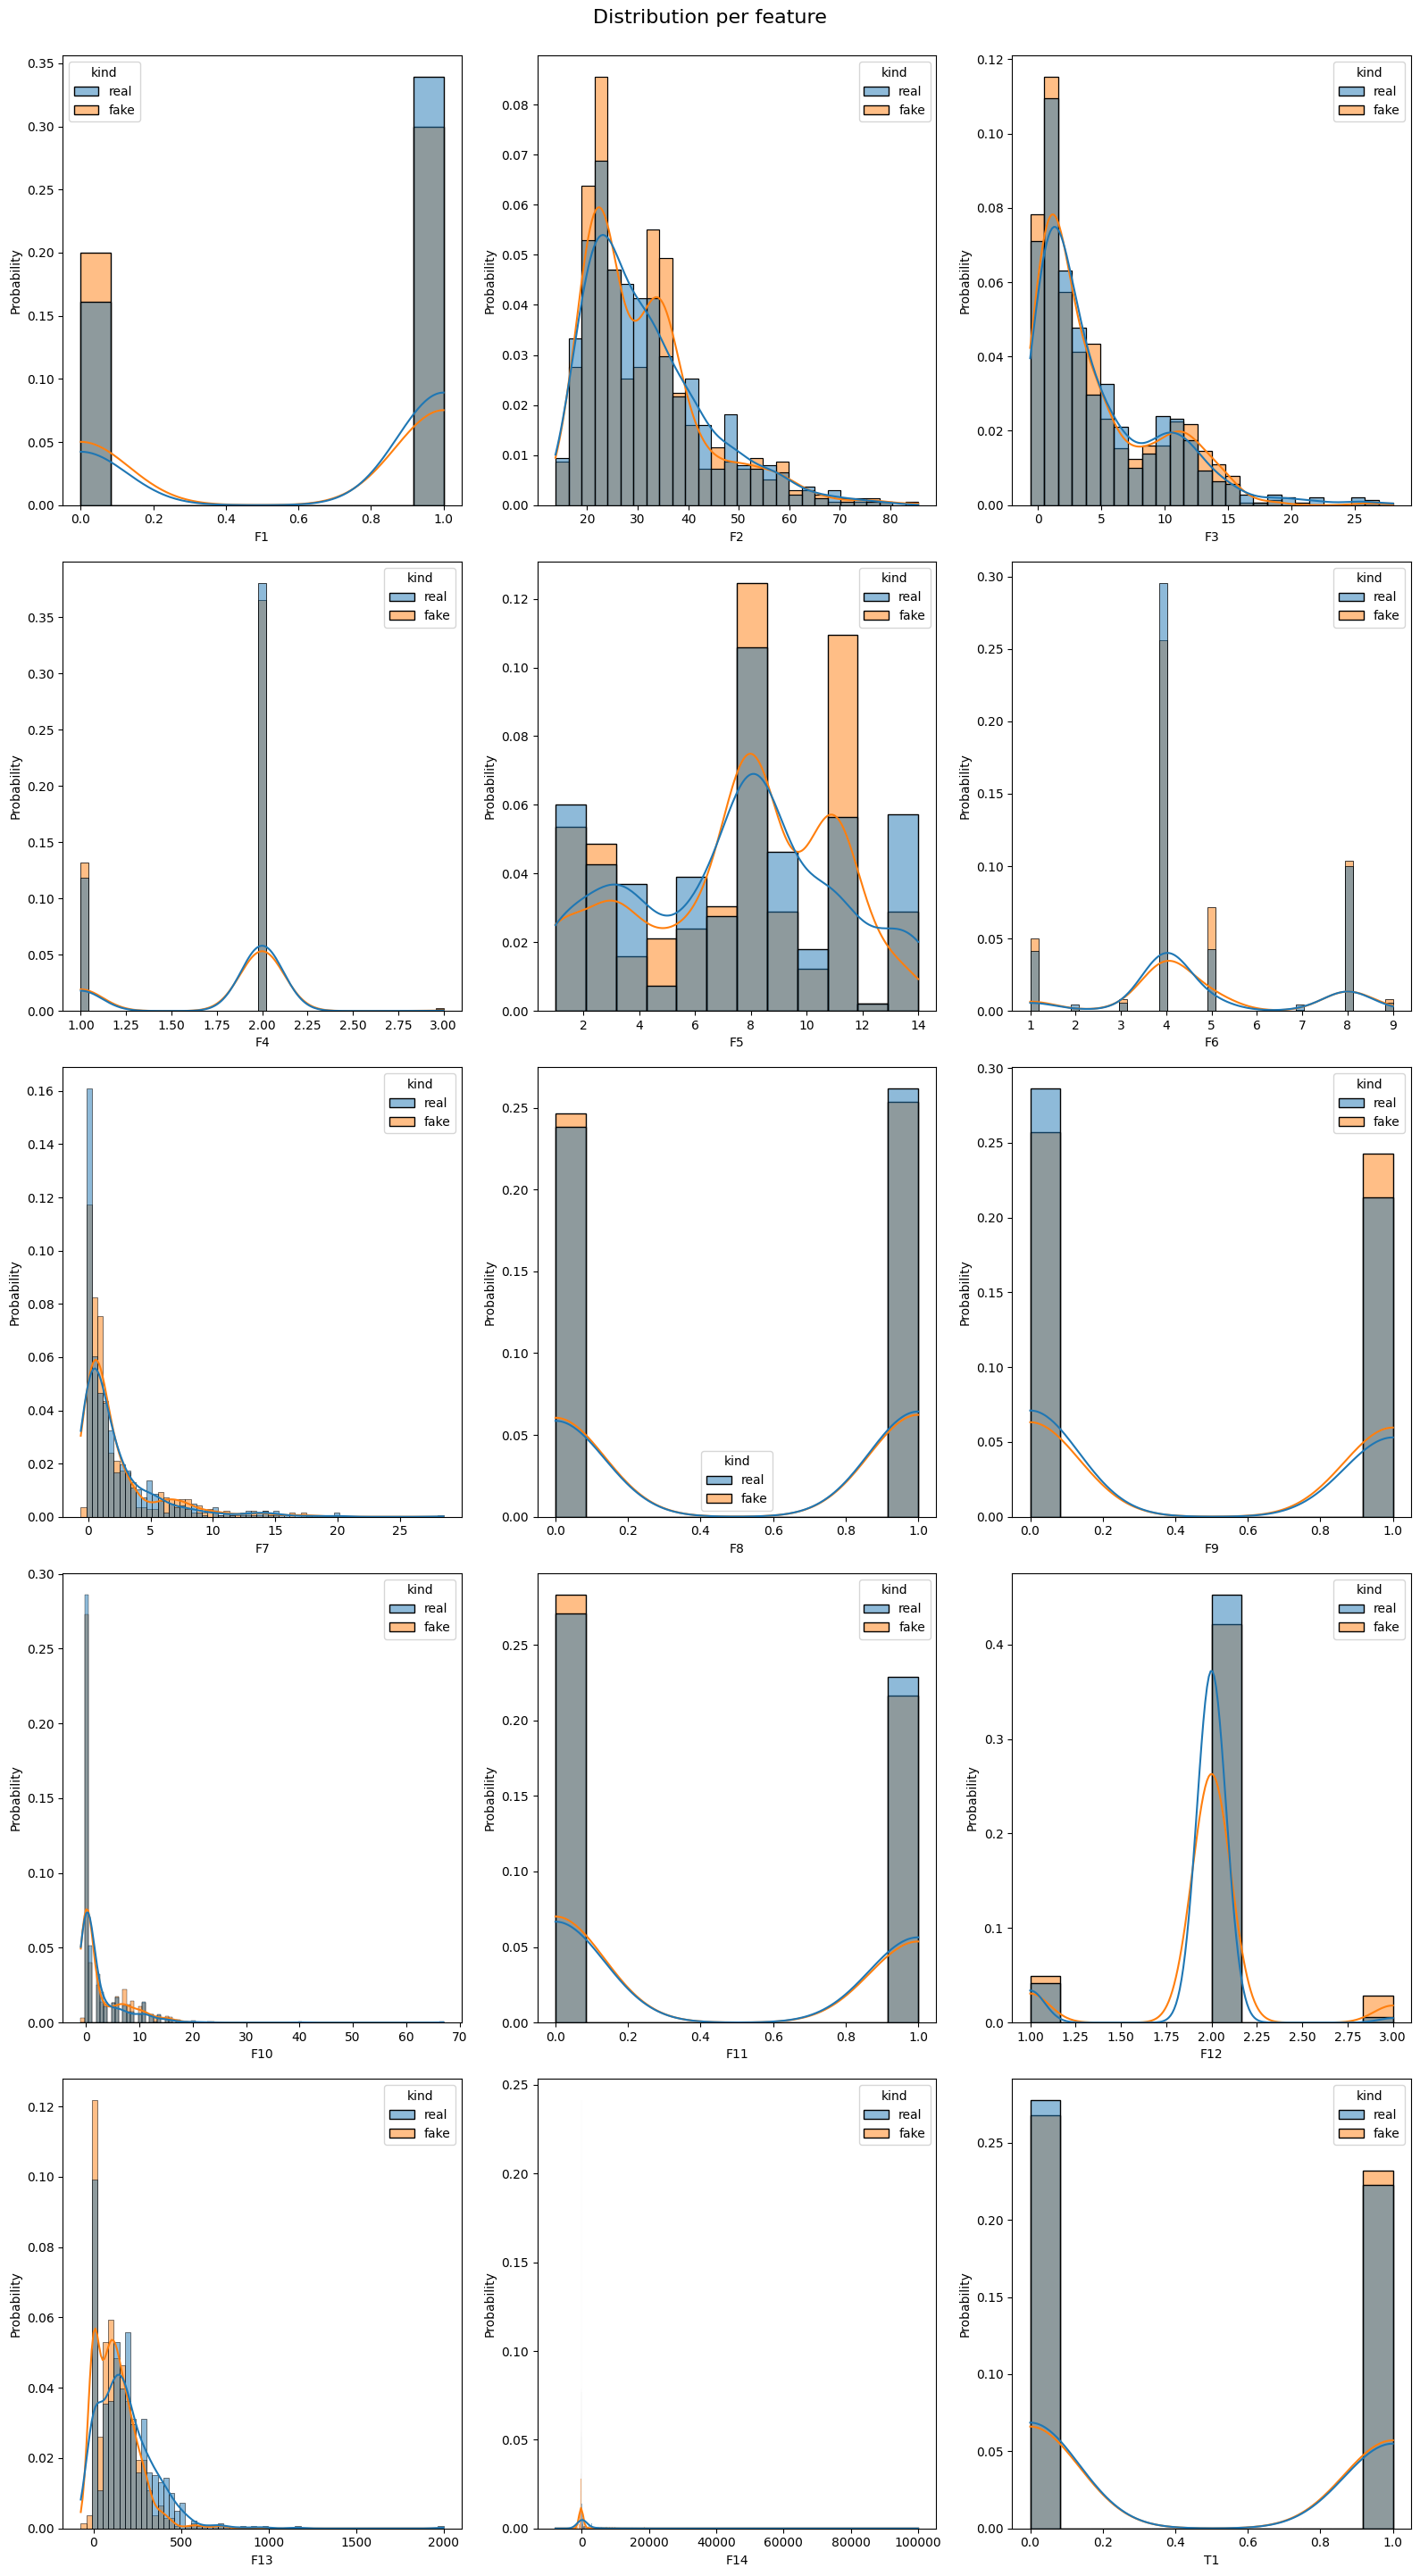

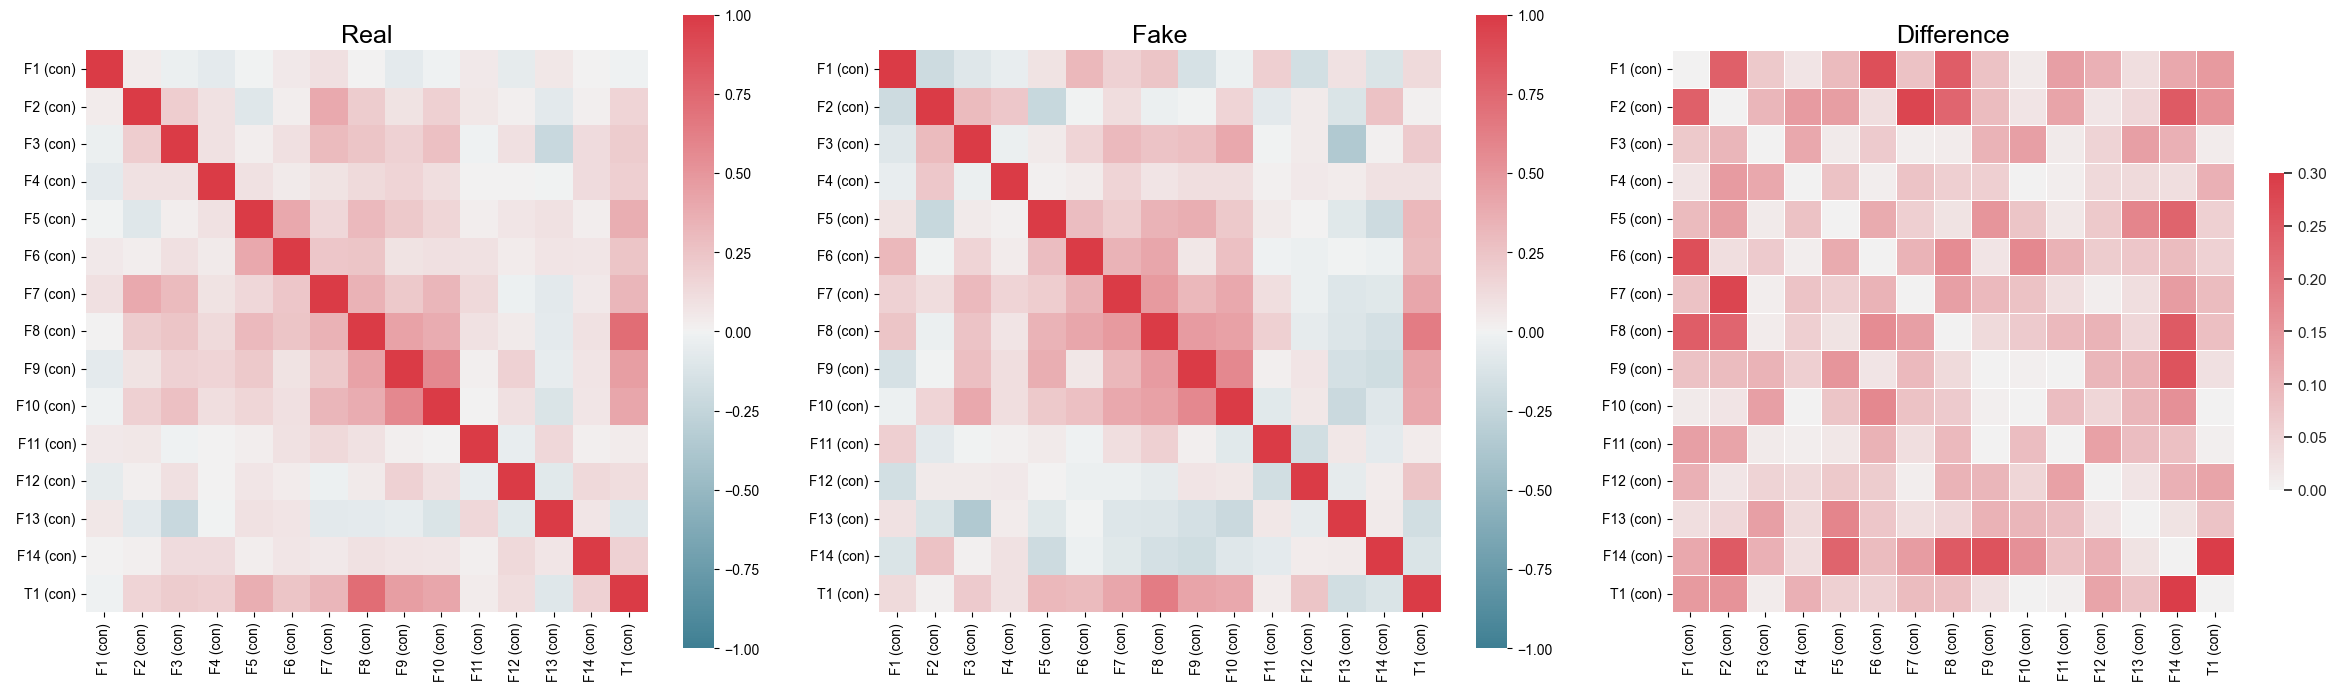

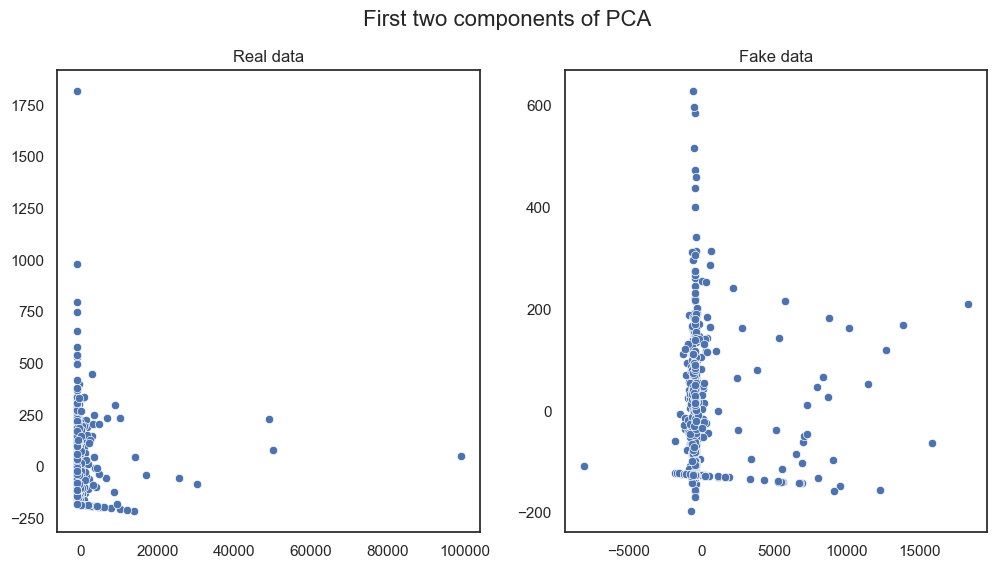

In [11]:
!pip install scipy==1.11.4
Real_Dataset = pd.read_csv('Real_Datasets/Approval/Approval.csv')
Fake_Dataset = pd.read_csv('Fake_Datasets/Approval/Approval_fake_0.csv')

Real_Dataset.head()
Real_Dataset.info()
Fake_Dataset.head()
Fake_Dataset.info()

print(Real_Dataset.shape, Fake_Dataset.shape)
table_evaluator = TableEvaluator(Real_Dataset, Fake_Dataset)

table_evaluator.visual_evaluation()